# Additional features of `Exponax`

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
import exponax as ex

## Repeated stepper for more accurate (or more stable) integration

The (conservative) second order Kuramoto-Sivshinsky stepper is unstable for a $\Delta t = 1.0$ under default configurations.

2024-03-01 14:59:05.217187: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.52). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


[nan nan nan nan]


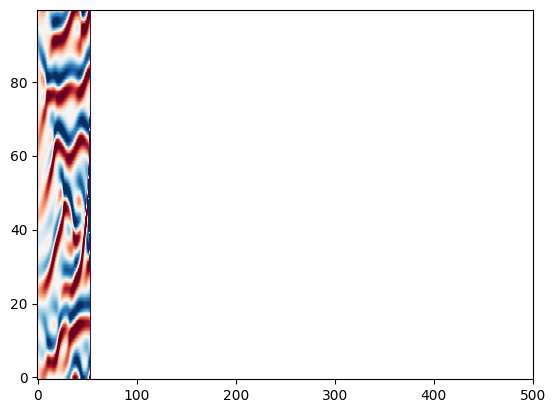

In [3]:
DOMAIN_EXTENT = 60.0
NUM_POINTS = 100
DT = 1.0

ks_stepper = ex.stepper.KuramotoSivashinskyConservative(
    1, DOMAIN_EXTENT, NUM_POINTS, DT
)

grid = ex.make_grid(1, DOMAIN_EXTENT, NUM_POINTS)
u_0 = jax.random.normal(
    jax.random.PRNGKey(0),
    (
        1,
        NUM_POINTS,
    ),
)  # Initial condition does not matter for KS equation

unstable_trj = ex.rollout(ks_stepper, 500, include_init=True)(u_0)

plt.imshow(
    unstable_trj[:, 0, :].T,
    aspect="auto",
    cmap="RdBu_r",
    vmin=-2,
    vmax=2,
    origin="lower",
)

print(unstable_trj[-1, 0, 1:5])  # All NaNs

We can instantiate a stepper that performs only half of that $\Delta t$ and
repeat it twice to get the same result. However, now it is stable.

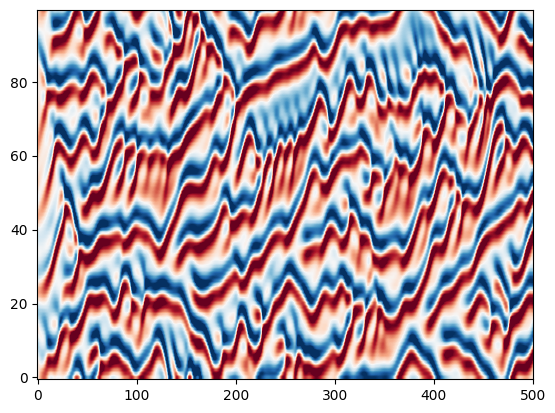

In [4]:
ks_stepper_half_step = ex.stepper.KuramotoSivashinskyConservative(
    1, DOMAIN_EXTENT, NUM_POINTS, DT / 2
)
ks_stepper_substepper = ex.RepeatedStepper(ks_stepper_half_step, 2)

stable_trj = ex.rollout(ks_stepper_substepper, 500, include_init=True)(u_0)

plt.imshow(
    stable_trj[:, 0, :].T, aspect="auto", cmap="RdBu_r", vmin=-2, vmax=2, origin="lower"
)

# Adding a forcing term

So far the steppers only consider "transient PDEs" that are not externally
forded. `Exponax` has a quick hack to turn a stepper of the signature $
\mathcal{P}: \R^{1 \times N} \mapsto \R^{1 \times N} $ into a stepper of the
signature $ \mathcal{P}: \R^{1 \times N} \times \R^{1 \times N} \mapsto \R^{1
\times N} $ which takes an additional forcing term. It is implemented by a
simple Euler integration before the actual ETDRK step. As such, it reduces the
overall temporal integration order to one.

Text(0.5, 1.0, 'Forced Heat Equation')

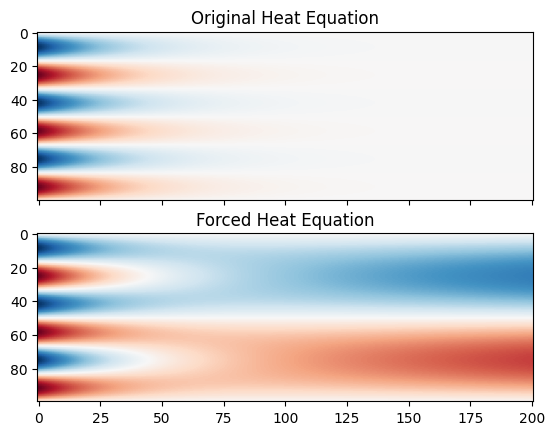

In [5]:
DOMAIN_EXTENT = 1.0
NUM_POINTS = 100
DT = 0.01
NU = 0.01

diffusion_stepper = ex.stepper.Diffusion(
    1, DOMAIN_EXTENT, NUM_POINTS, DT, diffusivity=NU
)
forced_diffusion_stepper = ex.ForcedStepper(diffusion_stepper)

grid = ex.make_grid(1, DOMAIN_EXTENT, NUM_POINTS)
u_0 = jnp.sin(6 * jnp.pi * grid / DOMAIN_EXTENT)

# Have a constant forcing term but we could also supply a time-dependent forcing
# trajectory
forcing = 0.5 * jnp.sin(2 * jnp.pi * grid / DOMAIN_EXTENT)

original_trj = ex.rollout(diffusion_stepper, 200, include_init=True)(u_0)
# We need to inform the rollout transformation that the signature of the stepper
# is different
forced_trj = ex.rollout(
    forced_diffusion_stepper, 200, include_init=True, takes_aux=True, constant_aux=True
)(u_0, forcing)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)
ax[0].imshow(original_trj[:, 0, :].T, aspect="auto", cmap="RdBu", vmin=-1, vmax=1)
ax[0].set_title("Original Heat Equation")
ax[1].imshow(forced_trj[:, 0, :].T, aspect="auto", cmap="RdBu", vmin=-1, vmax=1)
ax[1].set_title("Forced Heat Equation")

# Spectral derivatives

Any field discretized can be derived spectrally.

In [6]:
DOMAIN_EXTENT = 1.0
NUM_POINTS = 100

grid = ex.make_grid(1, DOMAIN_EXTENT, NUM_POINTS)
u = jnp.sin(6 * jnp.pi * grid / DOMAIN_EXTENT)
u_prime_exact = jnp.cos(6 * jnp.pi * grid / DOMAIN_EXTENT) * 6 * jnp.pi / DOMAIN_EXTENT

# You can select the order of differencing (first derivative, second derivative,
# etc.) with the `order` keyword argument
u_prime_spectrally = ex.derivative(u, DOMAIN_EXTENT)

# Results a very small value (~1e-5 when computed in single precision)
jnp.sqrt(jnp.mean(jnp.square(u_prime_exact - u_prime_spectrally)))

Array(4.742706e-05, dtype=float32)